## Basical settings

Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models
from astropy.modeling import functional_models
from astropy import units as u
import os, json, random, cv2
from PIL import Image
from numpyencoder import NumpyEncoder
import multiprocessing
import time
import torch

import utils

# for testing purpose
import importlib

plt.rcParams["figure.figsize"] = (15,10)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# !nvidia-smi
print(torch.__version__)
print(torch.cuda.is_available())

1.13.1
True


Global variables

In [3]:
wavelengths = np.arange(400, 800)*u.nm
FWHM        = 0.5
lambda_Na   = 589.0*u.nm
lambda_Mg   = 518.3*u.nm
width       = 1000
height      = 1500

## Generate dataset using multiprocessing: 

In [21]:
def generate_singledata(image_id, dir): 
    '''
    '''
    np.random.seed()
    filename = str(image_id) + "_" + time.strftime("%Y%m%d-%H%M%S") + ".jpg"
    print('generating image: %s...'%filename)
    # parameters
    num_stars       = 200
    x_stars         = (np.random.rand(num_stars)*(width-10*FWHM)+5*FWHM).astype(np.int16)
    y_stars         = (np.random.rand(num_stars)*(height-10*FWHM)+5*FWHM).astype(np.int16)
    # TODO: change the border where the meteor can show
    num_meteors     = 50
    length_meteors  = (np.random.rand(num_meteors)*50+150).astype(np.int16)                      # pixel
    x_meteors       = (np.random.rand(num_meteors)*(width-10*FWHM)+5*FWHM).astype(np.int16)
    y_meteors       = (np.random.rand(num_meteors)*(height-10*FWHM)+5*FWHM).astype(np.int16)
    # image - parameters needed for `generate_image` function
    coord_stars     = np.array([x_stars, y_stars]).T            # [N, 2]pixel
    amp_stars       = np.random.rand(num_stars)*1e8             # [N]erg -> pixel value
    T_stars         = (np.random.rand(num_stars)*15000+5000)*u.K# [N]5000K-20000K
    coord_meteors   = np.array([x_meteors, y_meteors]).T        # [n, 2]pixel
    amp_meteors     = np.random.rand(num_meteors)*1e7           # [n]erg -> pixel value
    T_meteors       = [2000*u.K]*num_meteors                    # [n]5000K-20000K
    angle_slit      = np.random.rand()*2*np.pi                  # radian
    angle_meteors   = [angle_slit + (np.random.rand()*2/3 + 1/6)*np.pi]*num_meteors       # [n]radian # maintain the symmetricity of a meteor
    length_slit     = 150
    # generate image
    image = utils.generate_image(coord_stars, amp_stars, T_stars, coord_meteors, amp_meteors, T_meteors, 
                                    angle_meteors, length_meteors, angle_slit, length_slit, 
                                    background = True, augmentation = False, lens_effect = False)
    im = Image.fromarray(image.astype(np.uint8))
    im.save(os.path.join(dir, filename), quality=100)
    # generate label
    lock.acquire()
    labels = json.load(open(os.path.join(dir, 'labels.json'), 'r'))
    labels = utils.annotate(labels, filename, image_id, coord_meteors, angle_meteors, length_meteors, 
                            angle_slit, length_slit, anno_id_shared, coord_stars)
    # rewrite json file everytime finishing generating an image
    with open(os.path.join(dir, 'labels.json'), 'w') as f:
        json.dump(labels, f, sort_keys=False, indent=2, separators=(',', ': '), cls=NumpyEncoder)
    lock.release()

    return image

generating image: 1_20230310-014556.jpg...


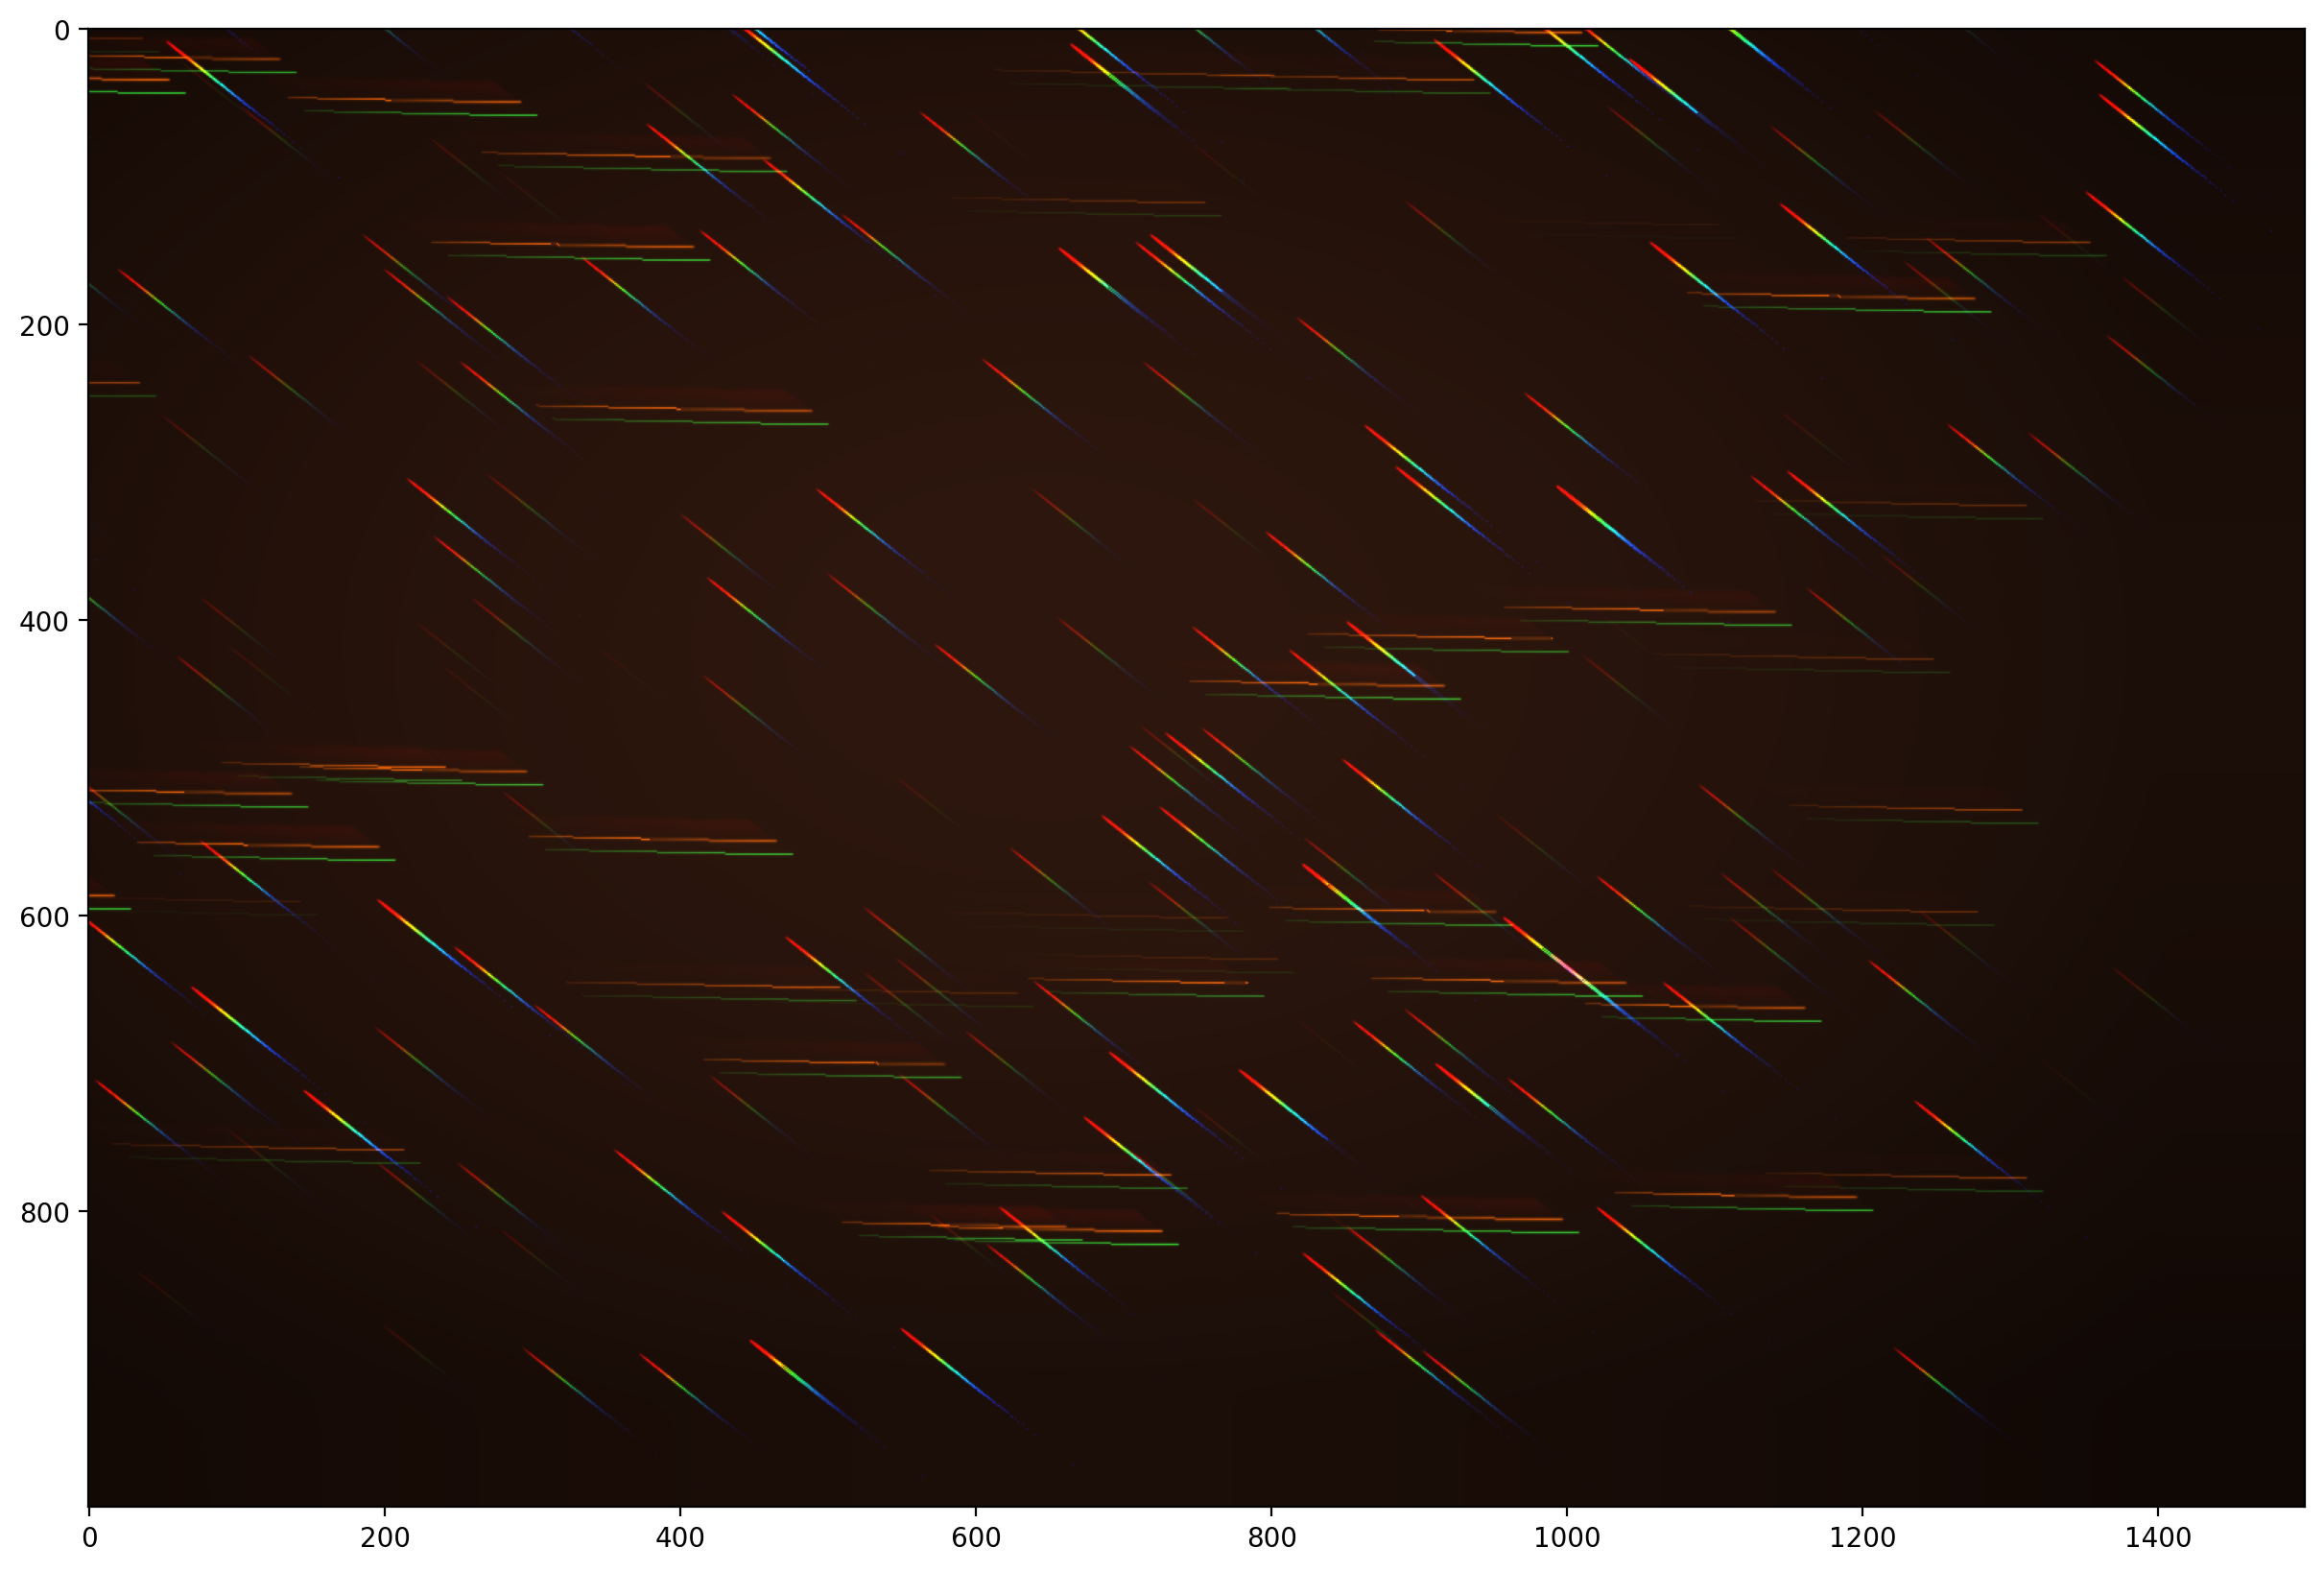

In [22]:
dir='./dataset0/'
os.makedirs(dir, exist_ok=True)

labels = utils.blank_label()
with open(os.path.join(dir, 'labels.json'), 'w') as f:
    json.dump(labels, f, sort_keys=False, indent=2, separators=(',', ': '), cls=NumpyEncoder)

num_images = 1

anno_id = 1
image_id = 1
manager = multiprocessing.Manager()
anno_id_shared = manager.Value('i', anno_id)
lock = multiprocessing.RLock()
args = zip(range(image_id, image_id + num_images), [dir]*num_images)
# with multiprocessing.Pool(processes=4) as pool:
#     results = pool.starmap(generate_singledata, args)

results = [generate_singledata(image_id, dir)]

plt.imshow(results[0])

In [18]:
importlib.reload(utils)

<module 'utils' from '/mnt/c/Users/Chisen/OneDrive - University of Illinois - Urbana/Research/Meteor spectrum/Metspec/utils.py'>

## Generate the second dataset 

which is more similar to our photos: 

* one meteor
* has background 
* 

In [58]:
def generate_singledata2(image_id, dir): 
    '''
    '''
    np.random.seed()
    filename = str(image_id) + "_" + time.strftime("%Y%m%d-%H%M%S") + ".jpg"
    print('generating image: %s...'%filename)
    # parameters
    num_stars       = 200
    x_stars         = (np.random.rand(num_stars)*(width-10*FWHM)+5*FWHM).astype(np.int16)
    y_stars         = (np.random.rand(num_stars)*(height-10*FWHM)+5*FWHM).astype(np.int16)
    # TODO: change the border where the meteor can show
    num_meteors     = 1
    length_meteors  = (np.random.rand(num_meteors)*200+300).astype(np.int16)                      # pixel
    x_meteors       = (np.random.rand(num_meteors)*(width-10*FWHM)+5*FWHM).astype(np.int16)
    y_meteors       = (np.random.rand(num_meteors)*(height-10*FWHM)+5*FWHM).astype(np.int16)
    # image - parameters needed for `generate_image` function
    coord_stars     = np.array([x_stars, y_stars]).T            # [N, 2]pixel
    amp_stars       = np.random.rand(num_stars)*1e8             # [N]erg -> pixel value
    T_stars         = (np.random.rand(num_stars)*15000+5000)*u.K# [N]5000K-20000K
    coord_meteors   = np.array([x_meteors, y_meteors]).T        # [n, 2]pixel
    amp_meteors     = np.random.rand(num_meteors)*1e7           # [n]erg -> pixel value
    T_meteors       = [2000*u.K]*num_meteors                    # [n]5000K-20000K
    angle_meteors   = np.random.rand(num_meteors)*2*np.pi       # [n]radian
    angle_slit      = np.random.rand()*2*np.pi                  # radian
    length_slit     = 150
    # generate image
    image = utils.generate_image(coord_stars, amp_stars, T_stars, coord_meteors, amp_meteors, T_meteors, 
                                    angle_meteors, length_meteors, angle_slit, length_slit, 
                                    background=True, augmentation=True, lens_effect=True, landscape=True)
    im = Image.fromarray(image.astype(np.uint8))
    im.save(os.path.join(dir, filename), quality=100)
    # generate label
    lock.acquire()
    labels = json.load(open(os.path.join(dir, 'labels.json'), 'r'))
    labels = utils.annotate(labels, filename, image_id, coord_meteors, angle_meteors, length_meteors, 
                            angle_slit, length_slit, anno_id_shared, coord_stars)
    # rewrite json file everytime finishing generating an image
    with open(os.path.join(dir, 'labels.json'), 'w') as f:
        json.dump(labels, f, sort_keys=False, indent=2, separators=(',', ': '), cls=NumpyEncoder)
    lock.release()

    return image

In [ ]:
dir='./dataset2/'
os.makedirs(dir, exist_ok=True)

labels = utils.blank_label()
with open(os.path.join(dir, 'labels.json'), 'w') as f:
    json.dump(labels, f, sort_keys=False, indent=2, separators=(',', ': '), cls=NumpyEncoder)

num_images = 1

anno_id = 1
image_id = 1
manager = multiprocessing.Manager()
anno_id_shared = manager.Value('i', anno_id)
lock = multiprocessing.RLock()
args = zip(range(image_id, image_id + num_images), [dir]*num_images)
with multiprocessing.Pool(processes=4) as pool:
    results = pool.starmap(generate_singledata2, args)

_ = plt.imshow(results[0])

In [83]:
results[0][750, 500]

array([255,  51,  47], dtype=uint16)

In [9]:
list(zip(zip(range(image_id_start, image_id_start + num_images), [dir]*num_images)))

[((1, './dataset2/'),),
 ((2, './dataset2/'),),
 ((3, './dataset2/'),),
 ((4, './dataset2/'),),
 ((5, './dataset2/'),),
 ((6, './dataset2/'),),
 ((7, './dataset2/'),),
 ((8, './dataset2/'),),
 ((9, './dataset2/'),),
 ((10, './dataset2/'),),
 ((11, './dataset2/'),),
 ((12, './dataset2/'),),
 ((13, './dataset2/'),),
 ((14, './dataset2/'),),
 ((15, './dataset2/'),),
 ((16, './dataset2/'),),
 ((17, './dataset2/'),),
 ((18, './dataset2/'),),
 ((19, './dataset2/'),),
 ((20, './dataset2/'),),
 ((21, './dataset2/'),),
 ((22, './dataset2/'),),
 ((23, './dataset2/'),),
 ((24, './dataset2/'),),
 ((25, './dataset2/'),),
 ((26, './dataset2/'),),
 ((27, './dataset2/'),),
 ((28, './dataset2/'),),
 ((29, './dataset2/'),),
 ((30, './dataset2/'),),
 ((31, './dataset2/'),),
 ((32, './dataset2/'),),
 ((33, './dataset2/'),),
 ((34, './dataset2/'),),
 ((35, './dataset2/'),),
 ((36, './dataset2/'),),
 ((37, './dataset2/'),),
 ((38, './dataset2/'),),
 ((39, './dataset2/'),),
 ((40, './dataset2/'),),
 ((41, '.

In [10]:
importlib.reload(utils)

<module 'utils' from '/mnt/c/Users/Chisen/OneDrive - University of Illinois - Urbana/Research/Meteor spectrum/Metspec/utils.py'>

In [83]:
a = [[[1, 2], [3, 4]]]
np.pad(a, ((1, 2), (3, 4), (0, 0)), 'edge')

array([[[1, 1, 1, 1, 2, 2, 2, 2, 2],
        [1, 1, 1, 1, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 4, 4, 4, 4, 4],
        [3, 3, 3, 3, 4, 4, 4, 4, 4],
        [3, 3, 3, 3, 4, 4, 4, 4, 4]]])